In [ ]:
!git clone https://github.com/Aryan1o1/Image-Restoration_.git
!mv Image-Restoration/* ./ 

Cloning into 'EE-769-Course-Project---Deep-Image-Prior'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 120 (delta 0), reused 0 (delta 0), pack-reused 117
Receiving objects: 100% (120/120), 23.24 MiB | 12.64 MiB/s, done.
Resolving deltas: 100% (39/39), done.


#Installing and Importing Dependencies


In [ ]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import argparse
import os

import numpy as np
from models import *

import torch
import torch.optim

from skimage.metrics import peak_signal_noise_ratio
from models.down_sampler_model import Downsampler

from sr_utils import *

torch.backends.cudnn.enabled= True
torch.backends.cudnn.benchmark=True
dtype=torch.cuda.FloatTensor


SyntaxError: ignored

# Specifications

In [ ]:
imsize=-1
factor= 4     #factor by which you want to upscale your image 
enforse_div32= 'CROP' #Need that the dimensions of the image is divisible by 32
PLOT =True

In [ ]:
path_to_image= 'data/zebra_GT.png'

#Loading Images with Baseline References 

HR and LR resolutions: (576, 384), (144, 96)
Low Resolution Image:


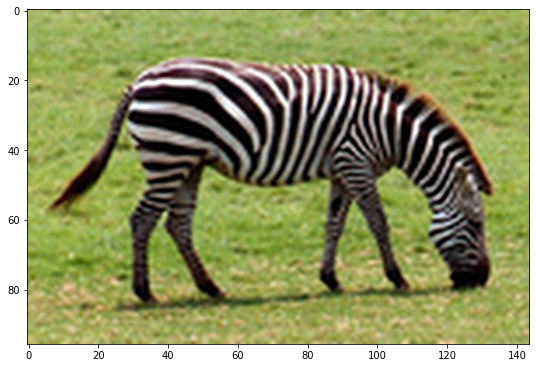

Ground Truth High Resolution Image:


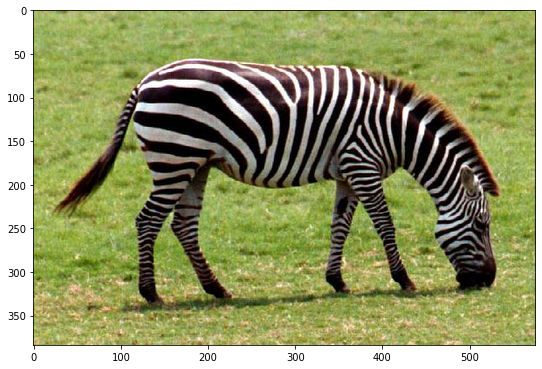

A Few Baseline Higher Resolution Images:
Bicubic Image:


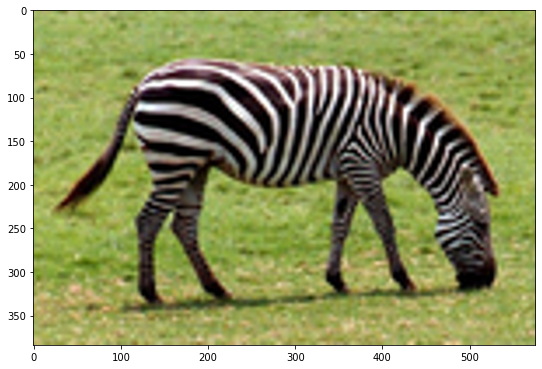

Bicubic Sharp Image:


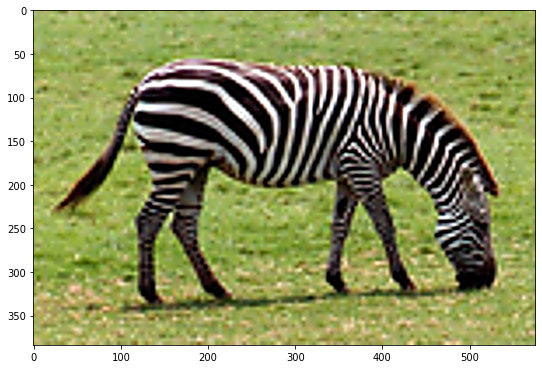

Nearest Image:


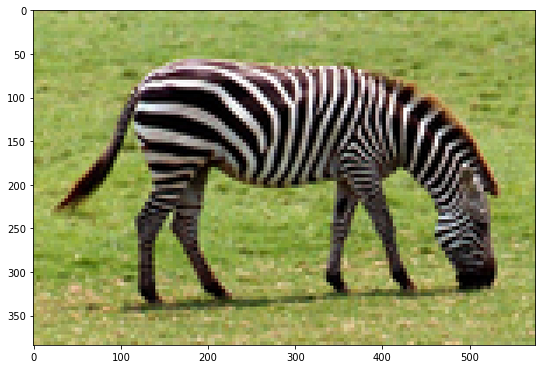

In [ ]:
images= load_LR_HR_imgs_sr(path_to_image,imsize,factor,enforse_div32)
images['bicubic_np'],images['sharp_bicub_np'],images['nearest_np']= get_baselines(images['LR_pil'],images['HR_pil'])

if PLOT:
  print('Low Resolution Image:')
  plot_image_grid([images['LR_np']],1,8)
  print('Ground Truth High Resolution Image:')
  plot_image_grid([images['HR_np']],1,8)
  print('A Few Baseline Higher Resolution Images:')
  print('Bicubic Image:')
  plot_image_grid([images['bicubic_np']],1,8)
  print('Bicubic Sharp Image:')
  plot_image_grid([images['sharp_bicub_np']],1,8)
  print('Nearest Image:')
  plot_image_grid([images['nearest_np']],1,8)

#Setting up the Net and Specifying parameters


In [ ]:
input_depth = 32 #32 channels of noise is sent as input

INPUT=   'noise'
pad  =   'reflection'
OPT_OVER=  'net'
Kernel_Type= 'lanczos2'

LR =0.01
tv_weight=0.0

OPTIMIZER = 'adam'

if factor==4:
  num_iter=2000
  reg_noise_std=0.03
else:
  assert False,'not experimented'

#generating input for the network

net_input= get_noise(input_depth,INPUT, (images['HR_pil'].size[1],images['HR_pil'].size[0])).type(dtype).detach()

#Creating a Neural Network with Skip Connections

NET_TYPE='skip'

net = get_net(input_depth,'skip',
              pad,skip_n33d=128,
              skip_n33u=128,
              skip_n11=4,
              num_scales=5,
              upsample_mode='bilinear').type(dtype)

s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 

print ('Number of params in skip net: %d' % s)

mse= torch.nn.MSELoss().type(dtype)
img_LR_sor= np_to_torch(images['LR_np']).type(dtype)

downsampler = Downsampler(n_planes=3, factor=factor, kernel_type=Kernel_Type, phase =0.5, preserve_size=True).type(dtype)

t  = sum([np.prod(list(p.size())) for p in downsampler.parameters()]); 
print ('Number of params in downsampler: %d' % t)

Number of params in skip net: 2217831
Number of params in downsampler: 2307


In [ ]:
#Let us see how the model looks.
!pip install torchsummary
from torchsummary import summary

summary(net, input_size=(32,384,576))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1         [-1, 32, 384, 576]               0
            Conv2d-2          [-1, 4, 384, 576]             132
       BatchNorm2d-3          [-1, 4, 384, 576]               8
         LeakyReLU-4          [-1, 4, 384, 576]               0
   ReflectionPad2d-5         [-1, 32, 386, 578]               0
            Conv2d-6        [-1, 128, 192, 288]          36,992
       BatchNorm2d-7        [-1, 128, 192, 288]             256
         LeakyReLU-8        [-1, 128, 192, 288]               0
   ReflectionPad2d-9        [-1, 128, 194, 290]               0
           Conv2d-10        [-1, 128, 192, 288]         147,584
      BatchNorm2d-11        [-1, 128, 192, 288]             256
        LeakyReLU-12        [-1, 128, 192, 288]               0
  ReflectionPad2d-13        [-1, 128, 192, 288]               0
           Conv2d-14          [-1, 4, 1

In [ ]:
summary(downsampler,input_size=(3,384,576))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
  ReplicationPad2d-1          [-1, 3, 396, 588]               0
            Conv2d-2           [-1, 3, 96, 144]           2,307
Total params: 2,307
Trainable params: 2,307
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 2.53
Forward/backward pass size (MB): 5.65
Params size (MB): 0.01
Estimated Total Size (MB): 8.19
----------------------------------------------------------------


#Fitting the model(net) 

In [ ]:
def closure():
  global i,net_input

  if reg_noise_std>0:
    net_input=net_input_saved+(noise.normal_()*reg_noise_std)

  out_HR= net(net_input)
  out_LR= downsampler(out_HR)

  total_loss= mse(out_LR,img_LR_sor)

  if tv_weight>0:
    total_loss = total_loss+ tv_weight*tv_loss(out_HR)

  total_loss.backward()

  psnr_LR = peak_signal_noise_ratio(images['LR_np'],torch_to_np(out_LR))
  psnr_HR = peak_signal_noise_ratio(images['HR_np'],torch_to_np(out_HR))
  

  print ('Iteration %05d    PSNR_LR %.3f   PSNR_HR %.3f' % (i, psnr_LR, psnr_HR), '\r', end='')

  psnr_history.append((psnr_LR,psnr_HR))

  if PLOT and i%200==0:
    out_HR_np= torch_to_np(out_HR)
    plot_image_grid([images['HR_np'],images['bicubic_np'],out_HR_np],3,12)

  i=i+1

  return total_loss

Starting optimization with ADAM


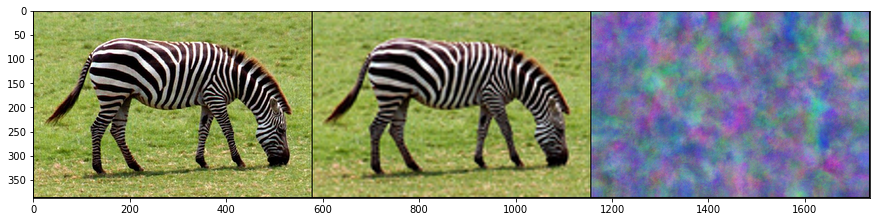

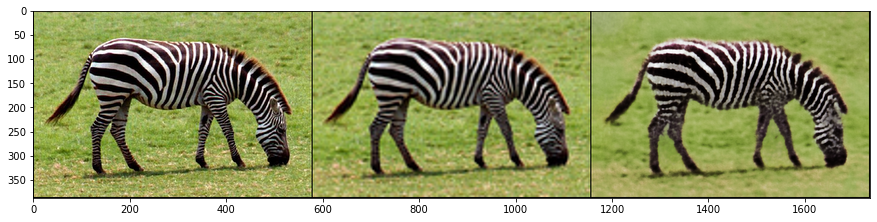

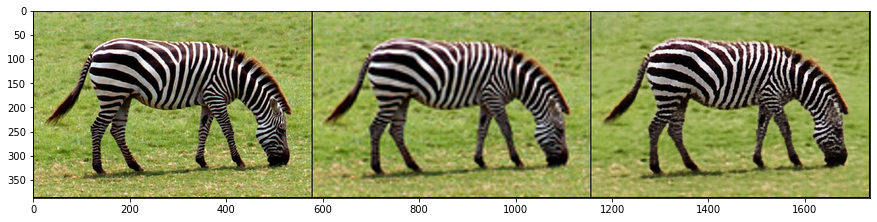

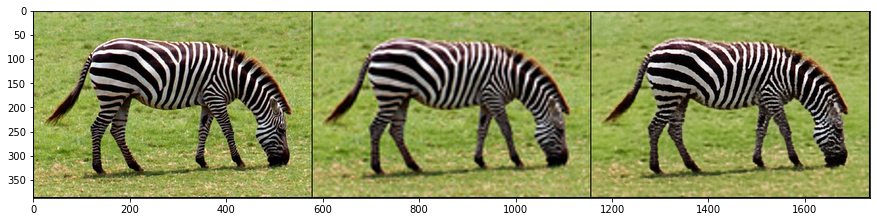

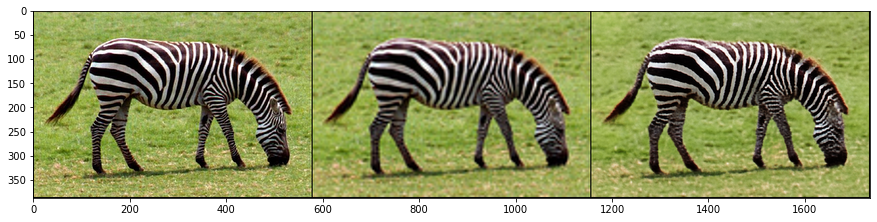

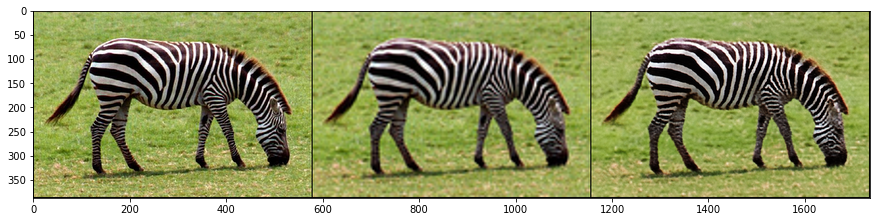

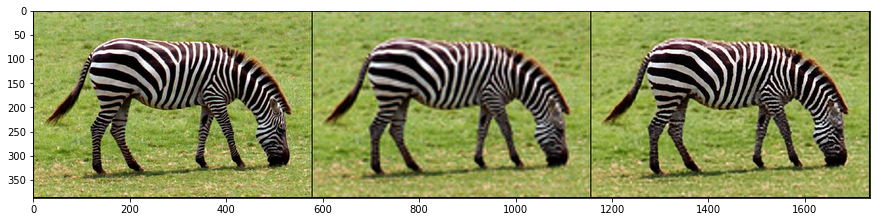

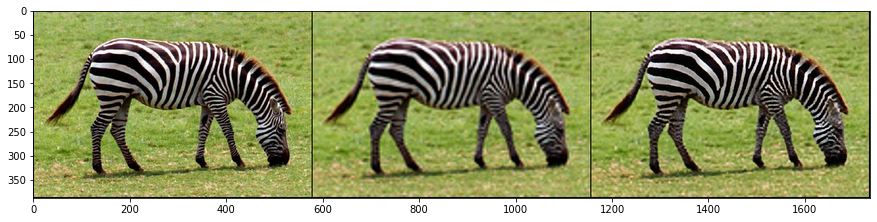

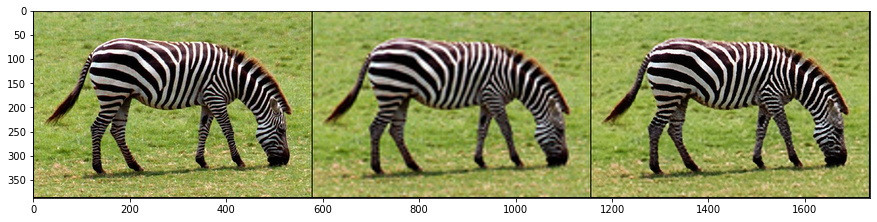

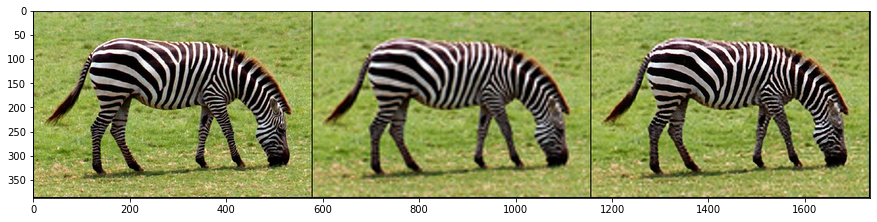

In [ ]:
psnr_history= []
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

i = 0
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

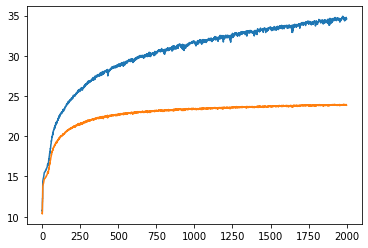

In [ ]:
import pandas as pd
df=pd.DataFrame(psnr_history,columns=['col1','col2'])
psnr_lr=df['col1']
psnr_hr=df['col2']
plt.plot(psnr_lr)
plt.plot(psnr_hr)
plt.show()

#Printing the Final Image 

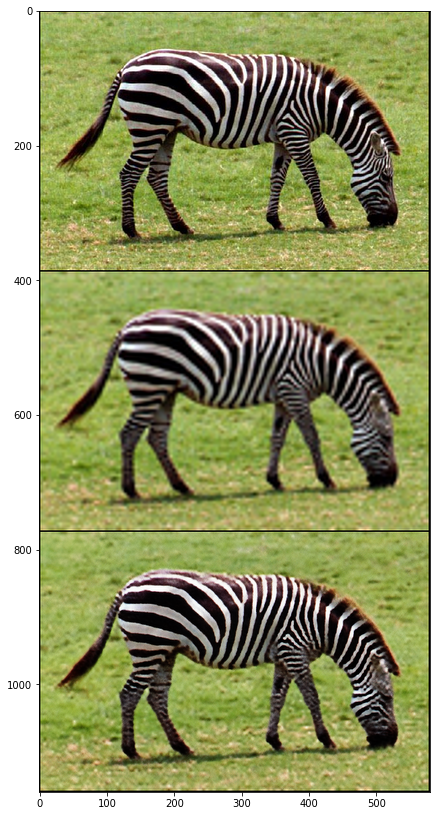

In [ ]:
out_HR_np = np.clip(torch_to_np(net(net_input)), 0, 1)
result_deep_prior = put_in_center(out_HR_np, images['orig_np'].shape[1:])

plot_image_grid([images['HR_np'],
                 images['bicubic_np'],
                 out_HR_np], factor=4, nrow=1);

In [ ]:
from google.colab import files
plt.savefig("abc.png")
files.download("abc.png") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>